In [1]:
1+1

2

In [2]:
# Generate dataset
import os
import pandas as pd
import numpy as np
from PIL import Image


#Load Training images and labels
train_directory = "./data/kaggle_train_128/train_128" #TODO: Enter path for train128 folder (hint: use os.getcwd())
image_list=[]
label_list=[]
for sub_dir in os.listdir(train_directory):
    print("Reading folder {}".format(sub_dir))
    sub_dir_name=os.path.join(train_directory,sub_dir)
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_list.append(np.array(Image.open(os.path.join(sub_dir_name,file))))
            label_list.append(int(sub_dir))
X_train=np.array(image_list)
y_train=np.array(label_list)

#Load Test images
test_directory = "./kaggle_test_128/test_128"#TODO: Enter path for test128 folder (hint: use os.getcwd())
test_image_list=[]
test_df = pd.DataFrame([], columns=['Id', 'X'])
print("Reading Test Images")
for file in os.listdir(test_directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        test_df = test_df.append({
            'Id': filename,
            'X': np.array(Image.open(os.path.join(test_directory,file)))
        }, ignore_index=True)
        
test_df['s'] = [int(x.split('.')[0]) for x in test_df['Id']]
test_df = test_df.sort_values(by=['s'])
test_df = test_df.drop(columns=['s'])
X_test = np.stack(test_df['X'])


print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)

Reading folder 0
Reading folder 1
Reading folder 2
Reading folder 3
Reading folder 4
Reading Test Images
Training data shape:  (15000, 128, 128, 3)
Training labels shape:  (15000,)
Test data shape:  (3500, 128, 128, 3)


In [3]:
X_t = X_train/255 
y_t = y_train/1.0

In [38]:
y_t = y_train/1.0

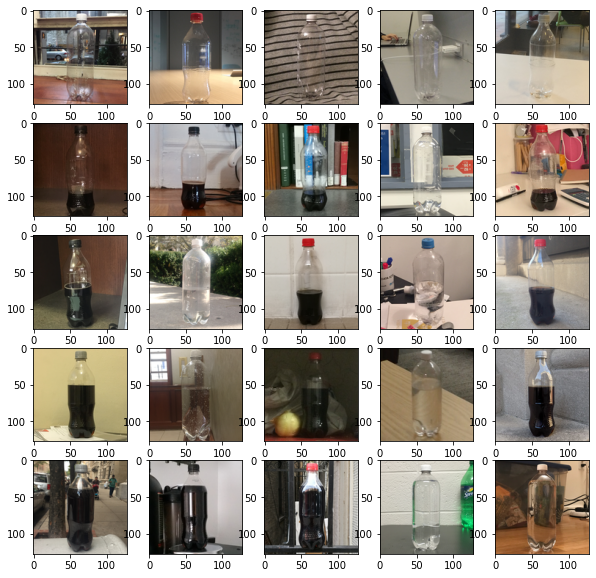

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

for i in range(5):
    
    for j in range(5):
        # print(i,j)
        ax = fig.add_subplot(5,5,i*5+ (j+1) )
        ax.imshow(X_t[3000*i + 200*j ])

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
import keras

In [6]:
# encoder, decoder and autocoder
# def encoder():
#     model = tf.keras.models.Sequential()
#     model.add(Flatten(input_shape=(128,128,3)))
#     model.add(Dense(128*64, activation='relu'))
#     model.add(Dense(128*4,activation = "relu"))
#     model.add(Dense(128,activation = "relu"))
#     return model


# def decoder():
#     model = tf.keras.models.Sequential()
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(128*4,activation = "sigmoid"))
#     model.add(Dense(128*128*3,activation = "sigmoid"))
#     model.add(tf.keras.layers.Reshape((128, 128,3), input_shape=(128*128*3,)))
#     return model

# def autoEncoder():
#     model = tf.keras.models.Sequential()
#     model.add(encoder())
#     model.add(decoder())
#     return model

# encoder, decoder and autocoder
def encoder():
    model = tf.keras.models.Sequential()

    model.add(AveragePooling2D(pool_size=2, strides=2))
    model.add(AveragePooling2D(pool_size=2, strides=2))
    model.add(AveragePooling2D(pool_size=2, strides=2))
    
    
#     model.add(Conv2D(filters=6, kernel_size=5, activation='tanh',padding='valid'))
#     model.add(AveragePooling2D(pool_size=2, strides=2))
#     model.add(Conv2D(filters=16, kernel_size=5, activation='tanh',padding='same'))
#     model.add(AveragePooling2D(pool_size=3, strides=3))
    
    model.add(Flatten())
    model.add(Dense(128*4,activation = "relu"))
    model.add(Dense(128,activation = "relu"))
    return model


def decoder():
    model = tf.keras.models.Sequential()
    model.add(Dense(128*4,activation = "sigmoid"))
    model.add(Dense(128*128*3,activation = "sigmoid"))
    model.add(tf.keras.layers.Reshape((128, 128,3), input_shape=(128*128*3,)))
    return model

def autoEncoder():
    model = tf.keras.models.Sequential()
    model.add(encoder())
    model.add(decoder())
    return model

In [11]:
# metric
def rounded_accuracy(y_true, y_pred): 
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred)) 

# optimizer
Adam = tf.keras.optimizers.Adam(0.001)
sgd = tf.keras.optimizers.SGD(1.5)

# loss
# loss = tf.keras.losses.BinaryCrossentropy

#Create the model, compile the model, and fit it
model_autoEncoder = autoEncoder()
model_autoEncoder.compile(optimizer=Adam,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[rounded_accuracy])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 3,restore_best_weights=True)

history1 = model_autoEncoder.fit(x=X_t, y=X_t, batch_size=256, epochs=100, validation_split = 0.2, callbacks = early_stopping )

Epoch 1/100
47/47 [==============================] - 21s 445ms/step - loss: 0.6701 - rounded_accuracy: 0.6223 - val_loss: 0.6484 - val_rounded_accuracy: 0.6989
Epoch 2/100
47/47 [==============================] - 20s 435ms/step - loss: 0.6441 - rounded_accuracy: 0.7261 - val_loss: 0.6371 - val_rounded_accuracy: 0.7378
Epoch 3/100
47/47 [==============================] - 20s 437ms/step - loss: 0.6285 - rounded_accuracy: 0.7660 - val_loss: 0.6182 - val_rounded_accuracy: 0.7719
Epoch 4/100
47/47 [==============================] - 20s 437ms/step - loss: 0.6180 - rounded_accuracy: 0.7889 - val_loss: 0.6088 - val_rounded_accuracy: 0.7941
Epoch 5/100
47/47 [==============================] - 21s 439ms/step - loss: 0.6135 - rounded_accuracy: 0.8024 - val_loss: 0.6048 - val_rounded_accuracy: 0.8049
Epoch 6/100
47/47 [==============================] - 21s 439ms/step - loss: 0.6097 - rounded_accuracy: 0.8128 - val_loss: 0.6036 - val_rounded_accuracy: 0.8065
Epoch 7/100
47/47 [=====================

Epoch 52/100
47/47 [==============================] - 21s 445ms/step - loss: 0.5818 - rounded_accuracy: 0.8801 - val_loss: 0.5715 - val_rounded_accuracy: 0.8788
Epoch 53/100
47/47 [==============================] - 21s 444ms/step - loss: 0.5823 - rounded_accuracy: 0.8779 - val_loss: 0.5715 - val_rounded_accuracy: 0.8787
Epoch 54/100
47/47 [==============================] - 21s 440ms/step - loss: 0.5815 - rounded_accuracy: 0.8808 - val_loss: 0.5714 - val_rounded_accuracy: 0.8793
Epoch 55/100
47/47 [==============================] - 20s 425ms/step - loss: 0.5814 - rounded_accuracy: 0.8811 - val_loss: 0.5710 - val_rounded_accuracy: 0.8800
Epoch 56/100
47/47 [==============================] - 20s 425ms/step - loss: 0.5815 - rounded_accuracy: 0.8801 - val_loss: 0.5711 - val_rounded_accuracy: 0.8796
Epoch 57/100
47/47 [==============================] - 20s 429ms/step - loss: 0.5811 - rounded_accuracy: 0.8818 - val_loss: 0.5708 - val_rounded_accuracy: 0.8802
Epoch 58/100
47/47 [==============

In [39]:
pretrained_encoder = tf.keras.Sequential(model_autoEncoder.layers[0])

pretrained_encoder.trianable = False

model_for_classification = tf.keras.Sequential([pretrained_encoder,
                                                Dense(30, activation='relu'),
                                                Dense(5, activation="softmax")])
# loss
# loss = tf.keras.losses.categorical_crossentropy()
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# metric
# categorical_acc = tf.keras.metrics.categorical_accuracy() 
categorical_acc  = tf.keras.metrics.CategoricalAccuracy()

# optimizer
Adam = tf.keras.optimizers.Adam(0.001)

# loss
# loss = tf.keras.losses.BinaryCrossentropy

#Create the model, compile the model, and fit it
model_for_classification .compile(optimizer=Adam,
                                  loss=loss,
                                  metrics=[categorical_acc ])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 3,restore_best_weights=True)



history2 = model_for_classification .fit(x=X_t, y=tf.one_hot(y_t, depth = 5), 
                                         batch_size=256, epochs=10, validation_split = 0.2, callbacks = early_stopping )

Epoch 1/10
47/47 [==============================] - 13s 263ms/step - loss: 2.3662 - categorical_accuracy: 0.2858 - val_loss: 9.2351 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
47/47 [==============================] - 1s 32ms/step - loss: 1.2101 - categorical_accuracy: 0.4611 - val_loss: 11.8554 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
47/47 [==============================] - 1s 28ms/step - loss: 1.0669 - categorical_accuracy: 0.5486 - val_loss: 12.8680 - val_categorical_accuracy: 0.0000e+00
Epoch 4/10
47/47 [==============================] - 1s 28ms/step - loss: 0.9896 - categorical_accuracy: 0.5779 - val_loss: 13.4670 - val_categorical_accuracy: 0.0000e+00


In [31]:
result1 = np.argmax(model_for_classification.predict(X_t)) - y_t
sum(np.abs(result1))

117.64705882353965

In [35]:
# Retrieve the config
config = model_autoEncoder.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
# custom_objects = {"CustomLayer": CustomLayer, "custom_activation": custom_activation}
# with keras.utils.custom_object_scope(custom_objects):
#     new_model = keras.Model.from_config(config)
    
custom_objects = {"Custom_metric": rounded_accuracy}
with keras.utils.custom_object_scope(custom_objects):
    new_model = keras.Model.from_config(config)

AttributeError: module 'keras.utils' has no attribute 'custom_object_scope'

In [37]:
import os

In [36]:
# config = model_autoEncoder.get_config()
# config

path = "./Test_model_for_task5/model_1"

if not os.path.exists("./model_1"):
    

load_model("./model_1")




{'name': 'sequential_9',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'sequential_10_input'}},
  {'class_name': 'Sequential',
   'config': {'name': 'sequential_10',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 128, 128, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'average_pooling2d_9_input'}},
     {'class_name': 'AveragePooling2D',
      'config': {'name': 'average_pooling2d_9',
       'trainable': True,
       'dtype': 'float32',
       'pool_size': (2, 2),
       'padding': 'valid',
       'strides': (2, 2),
       'data_format': 'channels_last'}},
     {'class_name': 'AveragePooling2D',
      'config': {'name': 'average_pooling2d_10',
       'trainable': True,
       'dtype': 'float32',
       'pool_size': (2, 2),
       'padding': 'valid',
       'strides': (2,

In [34]:
X_t[0].shape

(128, 128, 3)

In [30]:
model_autoEncoder.save("model_autoEncoder_1")

INFO:tensorflow:Assets written to: model_autoEncoder_1\assets


In [32]:
pretrained_encoder(X_t[0])

ValueError: Input 0 of layer sequential_20 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (128, 128, 3)